# Summary

- use splines for smooth variables like the bouyancy or the horizontal velocity
- use gaussian smoothing for very noisy variables like $w$ or $H$.

# Questions

- Can some shared approach be used for both? Perhaps using smoothing splines. The scales could be specified in terms of effective-degrees of freedom.

In [1]:
%pylab inline
mpl.style.use('seaborn')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from functools import partial
import xarray as xr
import pandas as pd
import gnl.xarray
from gnl.plots import plotiter
from lib.multiscale import chain_averages

In [3]:
nd = xr.open_dataset("wd/8aa7b/nondim.nc", chunks={'time': 200})

test_data = nd.U.isel(z=10).load()

In [6]:
def gauss_avg(test_data, l_sigma=1.0, t_sigma=1.0):
    dx = test_data.x[1] - test_data.x[0]
    dt = test_data.time[1] - test_data.time[0]
    n_sigma = l_sigma/dx
    nt_sigma = t_sigma/dt

    return test_data.ndimage.gaussian_filter1d('x', n_sigma)\
                    .ndimage.gaussian_filter1d('time', nt_sigma)

class GaussAvg(object):

    def msdecomp(self, A):
        """Performs meso-scale synoptic scale decomposition"""

        if A.chunks is None:
            A = A.chunk(A.shape)

        avgs = [
            partial(gauss_avg, l_sigma=1.0, t_sigma=1.0),
            partial(gauss_avg, l_sigma=5.0, t_sigma=5.0),
        ]

        scales = pd.Index(['m', 's', 'p'], name='scale')

        
        return xr.concat([a.load() for a in chain_averages(A, avgs)], 
                         dim=scales)

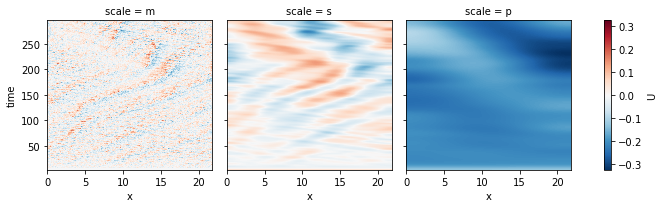

In [110]:
sca = GaussAvg().msdecomp(test_data)
sca.plot(col='scale')

this approach doesn't work very well for the horizontal velocity. I think the splines are more accurate, at least for removing the large-scale component. This approach really suffers from the fact that Gaussian averaging is not a projection. This approach might be more appropriate for the noisy fields like heating.

In [111]:
hms = nd.H.pipe(GaussAvg().msdecomp)

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/rechunk.py:347: RuntimeWarning: invalid value encountered in double_scalars
  key=lambda k: np.log(graph_size_effect[k]) / np.log(block_size_effect[k]),


These are some snapshots of the multiscale decomposition of H at the timestep of the model output.

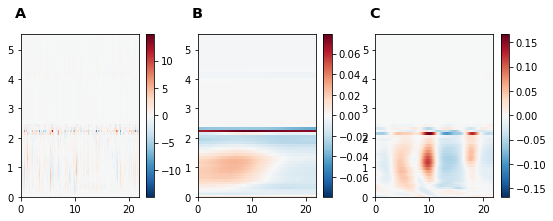

In [112]:
for sc, data in plotiter(hms.isel(time=-1).groupby('scale'), w=3, sharex=True, sharey=True, tight_layout=False):
    xr.plot.pcolormesh(data.squeeze(), x='x', y='z', add_labels=False)

Here are some hovmoller diagrams of the multiscale decomposition.

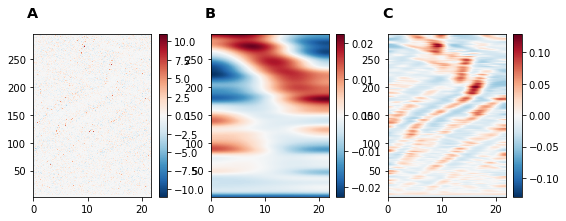

In [113]:
for sc, data in plotiter(hms.isel(z=15).groupby('scale'), w=3, sharex=True, sharey=True, tight_layout=False):
#     plt.figure()
    xr.plot.pcolormesh(data.squeeze(), x='x', y='time', add_labels=False)

# Penalized Regression using Fourier Modes

In [4]:
from gnl.spline import psplines, cardinal_splines
from scipy.optimize import fsolve

# n = len(nd.H.x)

# I = np.eye(n)
# F = fft.fft(I, axis=-1)
# IF = fft.ifft(I, axis=-1)
# k = np.diag(np.arange(n))

# dof = 2


def fourier_smoothing_mat(n, a=.1, dof=None, p=6.0):
    
    I = np.eye(n)
    F = fft.fft(I, axis=-1)
    IF = fft.ifft(I, axis=-1)
    
    k = fft.fftfreq(n,d=1/n)

    def filt(a,p):
        return np.diag(1/(1+exp(a)*np.abs(k)**p))

    if dof is None:
        N = filt(a,p)
        S = real(IF @ N @ F )
        return S

    else:

        def f(a):
            N = filt(a,p)
            return trace(N)-dof
        a = fsolve(f,0)
        return fourier_smoothing_mat(n, a=a, dof=None)



def fourier_trunc_mat(n, dof=None):
    
    I = np.eye(n)
    F = fft.fft(I, axis=-1)
    IF = fft.ifft(I, axis=-1)
    
    k = fft.fftfreq(n,d=1/n)

    N = np.diag(np.abs(k) <= dof/2)
    S = real(IF @ N @ F )
    return S


def cardspl_smoothing(x, dof=None):
    A= cardinal_splines(nd.x, dof).T
    S = A@pinv(A)
    return S

In [111]:
S1 = fourier_smoothing_mat(512, dof=20.0)
S2 = fourier_smoothing_mat(512, dof=3.0)


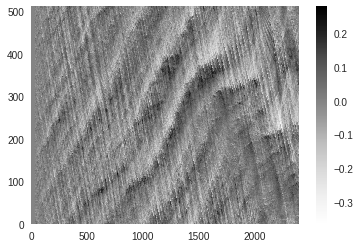

In [112]:
X = nd.U.isel(z=10).transpose('x', 'time').values

pcolormesh(X-S2@S1@X)
colorbar()

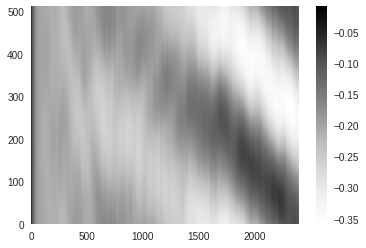

In [114]:
pcolormesh(S2@S1@X)
colorbar()

In [5]:
def dof_plot(f, x, dofs=(5,11,15,21,25), ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x,'k')
    for dof in dofs:
        S = f(dof=dof)
        ax.plot(S@x, label=f'dof={trace(S):.2f}')
    ax.legend()

Performance of penalized fourier method $N=(1+\alpha |k|^4)^{-1}$ (A), bare Fourier truncation (B), and splines (C) for different effective degrees of freedom (dof). These methods all can capture the synoptic scale (dof=20) fluctations well, but the planetary scale pattern obtained is substantially different between the methods. The spline and Fourier penalization methods allow for an attractive adaptivity in the inferred planetary scale structure, but the benefit is not large. 

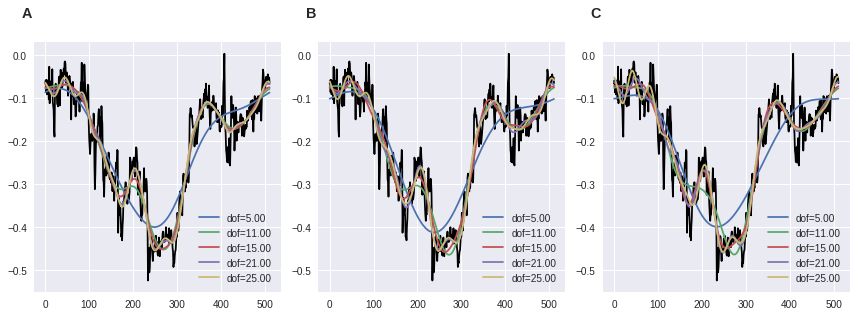

In [6]:
funs = [ partial(fourier_smoothing_mat, 512,p=6), 
            partial(fourier_trunc_mat, 512),
            partial(cardspl_smoothing,  nd.x)]


x = nd.U.isel(z=10,time=-1).values
for f in plotiter(funs,w=4, sharey=True, sharex=True):
    dof_plot(f, x)

How do these same methods perform on the much noiser $H$ variable? We are forced to use a logarithmic axis for the these plots.

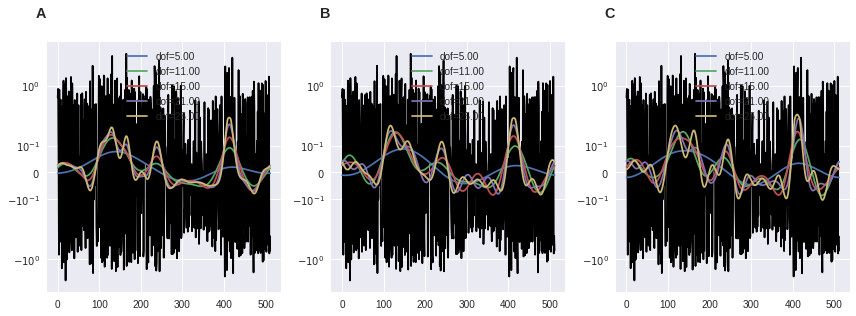

In [8]:
x = nd.H.isel(z=15,time=-1).values
for f in plotiter(funs,w=4, sharey=True, sharex=True):
    dof_plot(f, x)
    plt.gca().set_yscale('symlog', linthreshy=.2)

The performance is similar for low dof, but the Fourier penalization approach (A) yields substantially less noisy results for dof=21. For instance, look at the large oscillations in (B) and (C) for $300 < x<400$, where there is subtantially lower variance in $H$. In this region, the estimated curves for (B) and (C) are very sensitive to the number of dof, while the penalization method's estimates vary continuously with dof.

For these reasons, the penalized method seems to perform the best on both the horizontal velocity, which varies smoothly, and the noisy $w$ and $B$ fields. A similar penalization approach could be used with the spline basis, but the splines do not perform any better than the Fourier basis, and are more unfamiliar to an AOS audience.